# Photonic kernels

- Generate a dataset using the chip with $n$ photons
- Learn the dataset using $k \leq n$ photons
- Compare performance with standard Gaussian kernels

## Code to construct chips

In [5]:
from discopy.quantum.optics import MZI, BeamSplitter, PhaseShift, Id

def params_shape(width, depth):
    """ Returns the shape of parameters given width and depth. """
    even_width = not width % 2
    even_depth = not depth % 2
    if even_width:
        if even_depth:
            # we have width // 2 MZIs on the first row
            # followed by width // 2 - 1 equals width - 1
            return (depth // 2, width - 1, 2)
        else:
            # we have the parameters for even depths plus
            # a last layer of width // 2 MZIs
            return (depth // 2 * (width - 1) + width // 2, 2)
    else:
        # we have width // 2 MZIs on each row, where
        # the even layers are tensored by Id on the right
        # and the odd layers are tensored on the left.
        return (depth, width // 2, 2)


def ansatz(width, depth, x):
        """ Returns the chip given width, depth and parameters x"""
        params = x.reshape(params_shape(width, depth))
        chip = Id(width)
        if not width % 2:
            if depth % 2:
                params, last_layer = params[:-width // 2].reshape(
                    params_shape(width, depth - 1)), params[-width // 2:]
            for i in range(depth // 2):
                chip = chip\
                    >> Id().tensor(*[
                        MZI(*params[i, j])
                        for j in range(width // 2)])\
                    >> Id(1) @ Id().tensor(*[
                        MZI(*params[i, j + width // 2])
                        for j in range(width // 2 - 1)]) @ Id(1)
            if depth % 2:
                chip = chip >> Id().tensor(*[
                    MZI(*last_layer[j]) for j in range(width // 2)])
        else:
            for i in range(depth):
                left, right = (Id(1), Id()) if i % 2 else (Id(), Id(1))
                chip >>= left.tensor(*[
                    MZI(*params[i, j])
                    for j in range(width // 2)]) @ right
        return chip

## Initialise width and depth of chip

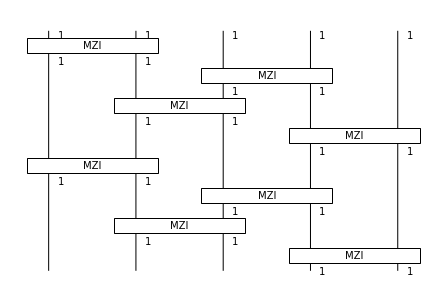

In [6]:
import numpy as np

depth = 4
width = 5
n_params = 2 * (depth * width // 2 - depth // 2)

random_datapoint = lambda: np.random.uniform(0, 2, size=(n_params,))

x0 = random_datapoint()
ansatz(width, depth, x0).draw()

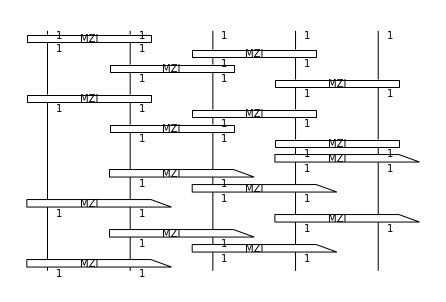

In [7]:
(ansatz(width, depth, x0) >> ansatz(width, depth, x0).dagger()).draw()

## Generate the dataset

In [8]:
from discopy.quantum.optics import occupation_numbers

n_photons = 3
a = [0, 1, 1, 1, 0]

def label(x):
    ''' Returns label of datapoint x, obtained by sampling from the chip with input state a'''
    basis_states = occupation_numbers(n_photons, width)
    chip = ansatz(width, depth, x)
    p_left = sum([np.absolute(chip.amp(a, b)) ** 2 for b in basis_states[:len(basis_states) // 2]])
    if p_left > .5:
        return 1
    else:
        return -1      

In [9]:
D = 120 # number of datapoints, must be even.

data = []
labels =[]
count_positive, count_negative, count_discarded = 0, 0, 0

while count_negative + count_positive < D:
        x = random_datapoint()
        y = label(x)
        if y == -1 and count_negative < D // 2:
            data += [x]
            labels += [y]
            count_negative += 1
        elif y == 1 and count_positive < D // 2:
            data += [x]
            labels += [y]
            count_positive += 1
        else:
            count_discarded += 1
        print('Number of positive samples: {}, Number of negative samples: {}'.format(
                count_positive, count_negative), end='\r')

assert sum(labels) == 0 
print('\nNumber of discarded samples: {}'.format(count_discarded))

Number of positive samples: 60, Number of negative samples: 60
Number of discarded samples: 23


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=1/4, random_state=115)
sum(y_train)

-4

# Learn dataset with photonic kernel

In [11]:
photonic_kernel = lambda state: lambda x0, x1: np.absolute(
                        (ansatz(width, depth, x0) >> ansatz(width, depth, x1).dagger()).amp(state, state)) ** 2

photonic_kernel(a)(data[4], data[4])

1.0000000000000009

In [12]:
from sklearn import svm
from sklearn.metrics import classification_report

classifier = svm.SVC(kernel='precomputed', verbose=True)

state = [0, 1, 1, 1, 0]

gram_train = np.array([[photonic_kernel(state)(x0, x1) for x1 in X_train] for x0 in X_train])
K3 = gram_train

# classifier.fit(gram_train, y_train)

# print('Performance on TRAIN data:')
# print(classification_report(y_train, classifier.predict(gram_train)))

In [9]:
gram_test = [[photonic_kernel(state)(x0, x1) for x1 in X_train] for x0 in X_test] 
print('Performance on TEST data:')
print(classification_report(y_test, classifier.predict(gram_test)))


Performance on TEST data:


NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## Learn dataset with less photons

In [13]:
state = [0, 1, 0, 1, 0]

gram_train = np.array([[photonic_kernel(state)(x0, x1) for x1 in X_train] for x0 in X_train])
K2 = gram_train
# # classifier.fit(gram_train, y_train)

# print('Performance on TRAIN data:')
# print(classification_report(y_train, classifier.predict(gram_train)))

# gram_test = [[photonic_kernel(state)(x0, x1) for x1 in X_train] for x0 in X_test] 

# print('Performance on TEST data:')
# print(classification_report(y_test, classifier.predict(gram_test)))

In [14]:
state = [0, 0, 1, 0, 0]

gram_train = np.array([[photonic_kernel(state)(x0, x1) for x1 in X_train] for x0 in X_train])
K1 = gram_train
# classifier.fit(gram_train, y_train)

# print('Performance on TRAIN data:')
# print(classification_report(y_train, classifier.predict(gram_train)))

# gram_test = [[photonic_kernel(state)(x0, x1) for x1 in X_train] for x0 in X_test] 

# print('Performance on TEST data:')
# print(classification_report(y_test, classifier.predict(gram_test)))

### Learn with distinguishable photons

In [15]:
dist_photons_kernel = lambda state: lambda x0, x1: (
        ansatz(width, depth, x0) >> ansatz(width, depth, x1).dagger()).D_prob(state, state)

state = [0, 1, 1, 1, 0]

gram_train = np.array([[dist_photons_kernel(state)(x0, x1) for x1 in X_train] for x0 in X_train])
K_D = gram_train
# classifier.fit(gram_train, y_train)

# print('Performance on TRAIN data:')
# print(classification_report(y_train, classifier.predict(gram_train)))

# gram_test = [[dist_photons_kernel(state)(x0, x1) for x1 in X_train] for x0 in X_test] 

# print('Performance on TEST data:')
# print(classification_report(y_test, classifier.predict(gram_test)))

## Compare with Gaussian kernels

In [72]:
grid.get_params

<bound method BaseEstimator.get_params of GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, ...,
       6.86648845e+01, 8.28642773e+01, 1.00000000e+02]),
                         'gamma': array([1.00000000e-09, 1.67683294e-09, 2.81176870e-09, ...,
       3.55648031e+01, 5.96362332e+01, 1.00000000e+02])})>

In [55]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

C_range = np.logspace(-2, 2, 50)
gamma_range = np.logspace(-9, 2, 50)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, ...,
       6.86648845e+01, 8.28642773e+01, 1.00000000e+02]),
                         'gamma': array([1.00000000e-09, 1.67683294e-09, 2.81176870e-09, ...,
       3.55648031e+01, 5.96362332e+01, 1.00000000e+02])})

In [73]:
print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

print('Performance on TRAIN data:')
print(classification_report(y_train, grid.predict(X_train)))

print('Performance on TEST data:')
print(classification_report(y_test, grid.predict(X_test)))

The best parameters are {'C': 0.01, 'gamma': 1e-09} with a score of 0.52
Performance on TRAIN data:
              precision    recall  f1-score   support

          -1       0.52      1.00      0.69        47
           1       0.00      0.00      0.00        43

    accuracy                           0.52        90
   macro avg       0.26      0.50      0.34        90
weighted avg       0.27      0.52      0.36        90

Performance on TEST data:
              precision    recall  f1-score   support

          -1       0.43      1.00      0.60        13
           1       0.00      0.00      0.00        17

    accuracy                           0.43        30
   macro avg       0.22      0.50      0.30        30
weighted avg       0.19      0.43      0.26        30



C:\Programs\Miniconda3\envs\discopy\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Programs\Miniconda3\envs\discopy\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Programs\Miniconda3\envs\discopy\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Programs\Miniconda3

In [ ]:
# import pickle
# pickle_out = open('dataset-D120-w5-d4-01110.pickle',"wb")
# pickle.dump(data, pickle_out)
# pickle_out.close()

# geometric difference

see Reference 
http://dx.doi.org/10.1038/s41467-021-22539-9

$$
g_{12} = g(K^1||K^2) = \sqrt{ || \sqrt{K^2}(K^1)^{-1}\sqrt{K^2} ||_{\inf} }
$$

In [44]:
#np.save('data.npy', (K1,K2,K3))

K1, K2, K3 = np.load('data.npy')


In [20]:
data

[array([0.42234051, 0.7814031 , 1.81470576, 1.65521259, 0.96798502,
        1.87102947, 0.55405159, 0.5646851 , 1.41977946, 1.29487278,
        1.02247353, 0.60404661, 0.82719138, 1.36221748, 1.4041428 ,
        0.79896805]),
 array([1.46254092, 0.18612518, 0.65283363, 1.01083445, 1.23078084,
        1.86204427, 1.42318671, 0.45753089, 1.46799292, 0.90902183,
        0.51584748, 1.51899218, 1.43199822, 0.03118849, 0.44422154,
        1.46318796]),
 array([0.11233918, 0.72233588, 1.38523091, 1.21025313, 0.72389449,
        1.71198239, 1.39202675, 0.22144624, 1.14955772, 1.21771303,
        0.32400232, 0.42331958, 0.49661106, 0.81515893, 1.95371453,
        0.57105515]),
 array([0.1519415 , 1.1152076 , 1.13380175, 1.26143436, 0.96238891,
        0.91497104, 1.49643744, 1.06455478, 0.19788137, 1.10757115,
        1.28040439, 1.06370499, 0.24856354, 0.43655152, 0.88209717,
        0.30906574]),
 array([1.38147039, 0.92138475, 1.25982249, 0.51017526, 0.37412245,
        1.38603484, 1.988946

In [53]:
np.sum(np.absolute(K1-0.1) < 0.001)

54

In [54]:
%matplotlib widget
import matplotlib.pyplot as plt
# plt.hist(K1)
plt.hist(K1, )
# plt.hist(K3)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([[29., 15., 14., ...,  1.,  0.,  1.],
        [31., 23., 16., ...,  0.,  0.,  1.],
        [30., 23., 15., ...,  2.,  0.,  1.],
        ...,
        [29., 21., 11., ...,  1.,  0.,  1.],
        [27., 25., 19., ...,  3.,  0.,  1.],
        [28., 27.,  9., ...,  1.,  1.,  1.]]),
 array([2.32449570e-04, 1.00209205e-01, 2.00185960e-01, 3.00162715e-01,
        4.00139470e-01, 5.00116225e-01, 6.00092980e-01, 7.00069735e-01,
        8.00046490e-01, 9.00023245e-01, 1.00000000e+00]),
 <a list of 90 BarContainer objects>)

In [31]:
from scipy.linalg import sqrtm
from numpy.linalg import matrix_power, norm, inv
def geo_diff(K1,K2):
    prod = np.dot( sqrtm(K2), inv(K1), sqrtm(K2) )
    print(f'inv: {np.max(inv(K1))}')
    print(f'root: {np.max(sqrtm(K2))}')
    print(f'prod: {np.max(prod)}')
    print(f'prod: {np.max(norm(prod, ord=np.inf))}')
    
    return np.sqrt(norm(prod, ord=np.inf))

geo_diff(K3,K3)

inv: -0.5624465755960446
root: 0.9927565578020799
prod: 1.1631647676176788
prod: 2.8872229642236285


1.699183028465041

In [30]:
print(geo_diff(K1,K1))
print(geo_diff(K2,K2))
print(geo_diff(K3,K3))
print(geo_diff(K1,K2))
print(geo_diff(K2,K3))
print(geo_diff(K3,K1))
print(geo_diff(K3,K2))
print(geo_diff(K2,K1))
print(geo_diff(K1,K3))

inv: 1.2253342792714684e+16
root: (0.6448192006097427-5.158627036371979e-10j)
prod: (2949504142.391997-477381593.92688215j)
prod: 69966499940.9978
264511.8143694111
inv: 5.89675161413346
root: 0.9613129693965253
prod: 2.1223885840568237
prod: 8.689621975613594
2.947816475904427
inv: 1.4708657702678494
root: 0.9927565578020799
prod: 1.1631647676176788
prod: 2.8872229642236285
1.699183028465041
inv: 1.2253342792714684e+16
root: 0.9613129693965253
prod: 8772691896749823.0
prod: 2.3232673710106867e+17
482002839.30809855
inv: 5.89675161413346
root: 0.9927565578020799
prod: 5.596869730147134
prod: 32.093607586415324
5.665122027495553
inv: 1.4708657702678494
root: (0.6448192006097427-5.158627036371979e-10j)
prod: (0.8309499824941019-8.703720319788865e-09j)
prod: 8.2068022570386
2.864751692038701
inv: 1.4708657702678494
root: 0.9613129693965253
prod: 1.3549285757642506
prod: 5.663488792340277
2.3798085621201293
inv: 5.89675161413346
root: (0.6448192006097427-5.158627036371979e-10j)
prod: (2.87

In [62]:
np.dot(matrix_power(K1,-1),K1)

array([[  30.33943207,  -24.39552892,    9.59610634, ...,   12.25500602,
          64.        ,   -8.        ],
       [  -4.62565806,  -47.54967267,  -64.73179367, ...,  -79.64921295,
         -16.75      , -100.75      ],
       [ -57.32218599,   23.407069  ,  -11.35256494, ...,   61.2950424 ,
         -51.        ,   -0.25      ],
       ...,
       [   6.        ,    1.5       ,    1.        , ...,    6.5       ,
           3.        ,    9.        ],
       [   3.        ,   -2.5       ,   -2.25      , ...,    0.        ,
           4.375     ,    9.        ],
       [  -1.21875   ,   -0.375     ,    2.        , ...,    1.75      ,
          -2.3125    ,    2.        ]])

In [52]:
MM = np.ones([4,4])
geo_diff(MM,MM)

Failed to find a square root.


LinAlgError: Singular matrix